# Семинар №2. Обработка сигналов

In [2]:
import cv2
import skimage.io
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

plt.style.use('seaborn')
%matplotlib inline

# Преобразование Фурье

Давайте поговорим немного о частотном пространстве перед тем, как углубимся в детали. Термин частота происходит из физики, как некоторое изменение во времени, описание характеристики некоторого периодического движения или поведения. Например, термин частота в компьютерном зрении обычно связан с вариацией яркости или цвета вдоль изображения, то есть является функцией пространственных координат, а не времени. Некоторые книги даже называют ее пространственной частотой (spatial frequency).

Например, если изображение, представленное в частотном пространстве, имеет высокие частоты, то это означает, что на нем присутствуют острые углы или детали. Давайте посмотрим на рисунки ниже, слева изображено исходное изображение, а справа — частотный график этой картинки.

In [3]:
def centered_spectrum(image):
    """
    Применить Фурье преобразование и сдвиг к заданному изображению
    """
    spectrum = np.fft.fft2(image)
    spectrum = np.fft.fftshift(spectrum)
    
    return spectrum

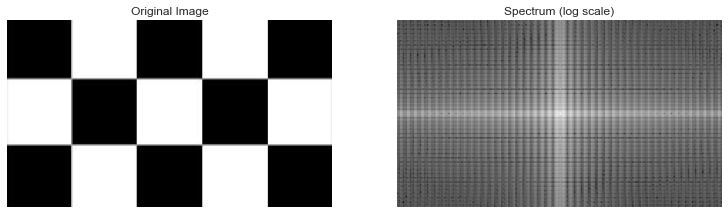

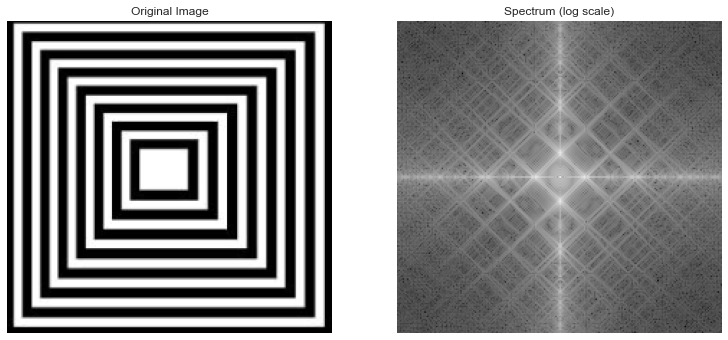

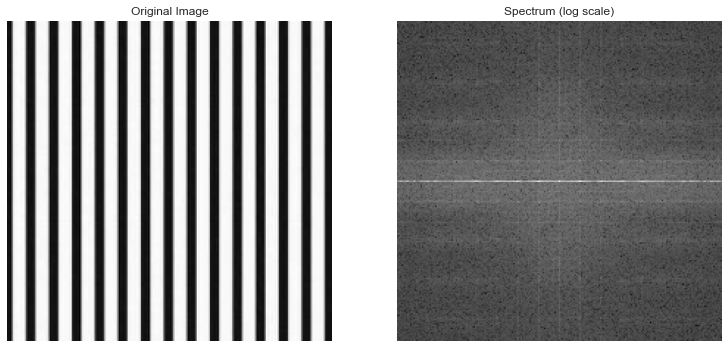

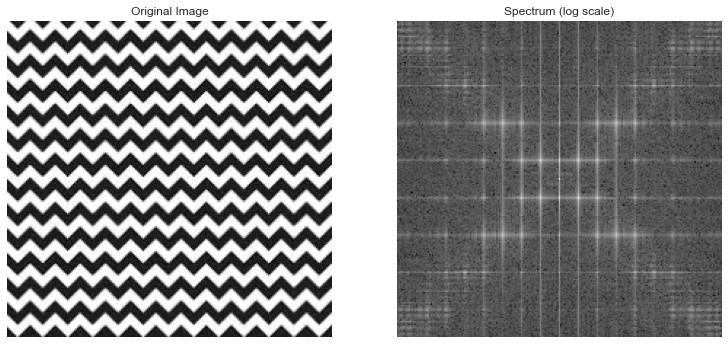

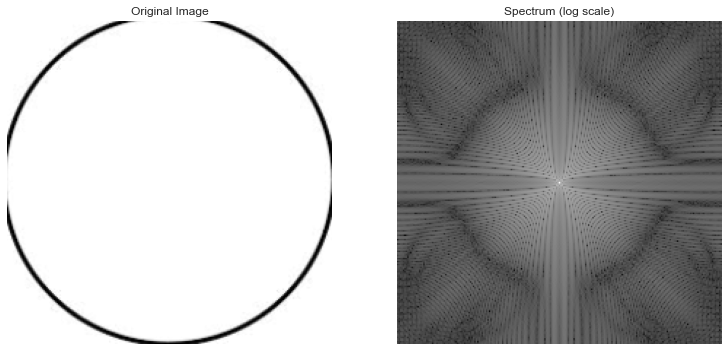

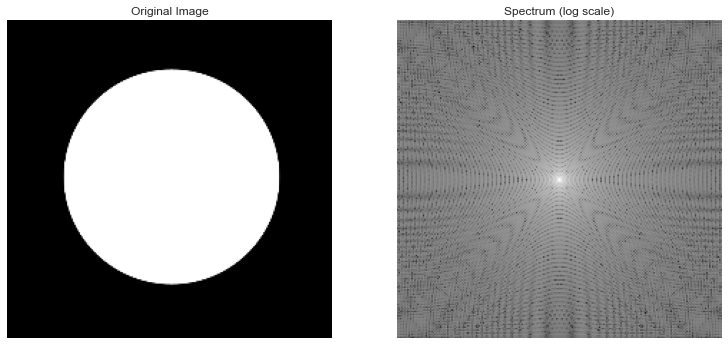

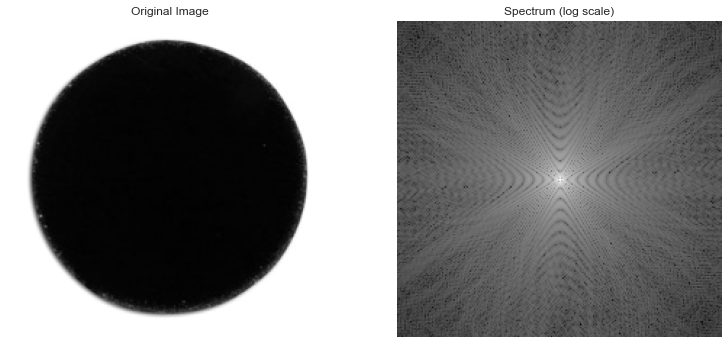

In [5]:
test_images = Path('img').rglob('test_freq*')  # собрать пути тестовых изображений

for fname in test_images:
    image = cv2.imread(str(fname), 0)  # чтение ЧБ изображения
    spectrum = centered_spectrum(image)

    plt.figure(figsize=(6.4 * 2, 4.8 * 2), constrained_layout=False)
    plt.subplot(121), plt.imshow(image, "gray"), plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(122), plt.imshow(1 + np.log(np.abs(spectrum)), "gray"), plt.title("Spectrum (log scale)")
    plt.axis('off')
    
    plt.show()

Если у вас возникли проблемы с пониманием частотных графиков: члены ряда с низкой частотой находятся в центре квадрата, а члены с высокой частотой — на краях. Представьте невидимые оси с началом координат в центре квадрата. Теперь, частотное пространство на первой сверху слева картинке состоит как из высоких частот, так и из низких, поэтому исходное изображение имеет резкие границы. Однако второе изображение более нечеткое, и, конечно, график частоты для него имеет меньше высокочастотных членов.

Частотная область вносит существенные преимущества в обработку изображений (image processing). Она позволяет делать крупные операции фильтрации гораздо быстрее. Так как информация об изображении хранится в частотах, то это позволяет иногда отделить сигнал от шума, а также осуществлять различные вычисления, которые были бы очень трудоемкими в пространственной области. Кроме того Fourier Transform позволяет легко осуществлять переход из пространственной области в частотную и наоборот.

Например, допустим, у нас есть изображение с некоторым периодичным шумом, который мы хотели бы устранить. (Представьте себе отсканированную страницу с сероватыми полосами.) Если перевести данные изображения в частотное пространство, то любой периодический шум в исходной картинке будет отображаться как яркие пятна на диаграмме в частотном пространстве. Если мы устраним эти точки и применим inverse Fourier Transform, чтобы получить исходное изображение, мы сможем удалить большую часть шума и тем самым улучшить видимость изображения.

Начальное изображение:

In [4]:
# проверим онодзначность Фурье преобразования к изображению
img_c1 = cv2.imread('img/lena_noise_image.png', 0)
img_c2 = np.fft.fft2(img_c1)  # преобразование Фурье
img_c3 = np.fft.fftshift(img_c2)  # fft сдвиг
img_c4 = np.fft.ifftshift(img_c3)  # обратный fft сдвиг
img_c5 = np.fft.ifft2(img_c4)  # обратное преобразование Фурье

img_pix_dif = np.sum(img_c1 - img_c5.real)
print(f'Разница картинок составляет: {img_pix_dif:.5f}')

Разница картинок составляет: 0.00000


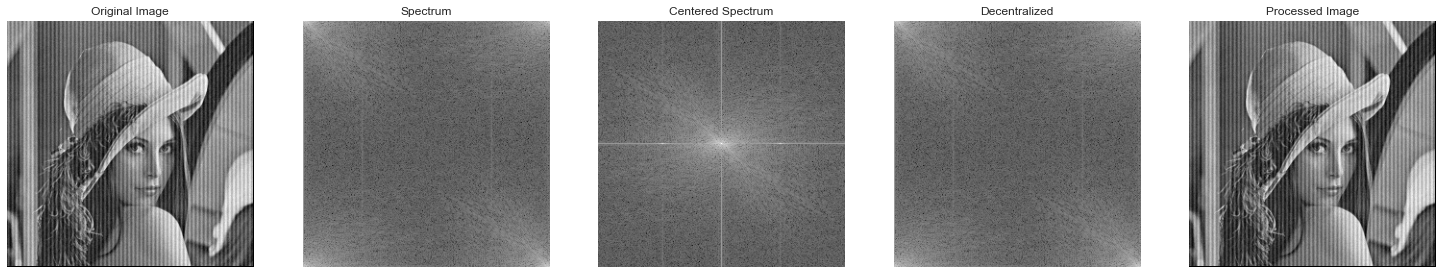

In [5]:
plt.figure(figsize=(6.4 * 4, 4.8 * 1), constrained_layout=False)

plt.subplot(151), plt.imshow(img_c1, 'gray'), plt.title('Original Image'), plt.axis('off')
plt.subplot(152), plt.imshow(np.log(1 + np.abs(img_c2)), 'gray'), plt.title('Spectrum'), plt.axis('off')
plt.subplot(153), plt.imshow(np.log(1 + np.abs(img_c3)), 'gray'), plt.title('Centered Spectrum'), plt.axis('off')
plt.subplot(154), plt.imshow(np.log(1 + np.abs(img_c4)), 'gray'), plt.title('Decentralized'), plt.axis('off')
plt.subplot(155), plt.imshow(np.abs(img_c5), 'gray'), plt.title('Processed Image'), plt.axis('off')

plt.show()

## Вспомним уравнения

Пусть $f(x)$ — непрерывная функция вещественной переменной  $x$. Преобразование Фурье (Fourier Transform) функции  $f(x)$  определяется уравнением:

$F(u)=\int^{-\infty}_{\infty}f(x)e^{-i2\pi ux}\,dx$

где  $i=\sqrt{-1}$  и  u  часто называется частотной переменной. Суммирование синусов и косинусов может быть не таким очевидным на первый взгляд, но, применяя уравнение Эйлера, получаем:

$F(u)=\int^{-\infty}_{\infty}f(x)(cos 2\pi ux -i sin 2\pi ux)\,dx$

По данному $F(u)$ мы можем вернуться назад и получить $f(x)$, используя обратное преобразование Фурье (inverse Fourier Transform):

$f(x)=\int^{-\infty}_{\infty}F(u)e^{i2\pi ux}\,dx$

Обратите внимание, что единственная разница между прямым и обратным преобразованием Фурье это знак, который легко позволяет перемещаться назад и вперед между пространственным и частотным областями; это одна из характеристик, которые делают преобразование Фурье полезным.

Некоторые могут спросить, что же такое  $F(u)$.  $F(u)$ это как раз данные в частотном пространстве, о котором мы говорили в первой секции. Даже если мы начинаем с вещественной функции $f(x)$  в пространственной области, мы обычно заканчиваем комплексными значениями  $F(u)$. Это происходит потому, что вещественное число, умноженное на комплексное, дает комплексное число.

Итак, $f(x)e^{i2\pi ux}$  — комплексное, поэтому сумма этих членов должна также дать комплексное число, то есть  $F(u)$. Поэтому,

$F(u)=R(u)+iI(u)$

где $R(u)$ является вещественной компонентой (члены, не содержащие  $i$) и  $I(u)$ есть комплексная компонента (члены, содержащие $i$); $(u)$ написано, чтобы напомнить, что члены являются функциями от $u$. Как любые другие комплексные числа, мы также можем записать их в полярной форме, дающей:

$F(u)=r(sin \theta + i cos \theta)=re^{i\theta}$

В большинстве учебников эта форма Fourier Transform записывается в виде:

$F(u)=\left|F(u)\right|e^{i\theta(u)}$

но это по сути одно и то же.

Существует несколько часто используемых слов, когда речь идет о преобразовании Фурье.  Модуль  $\left|F(u)\right|$ называется спектром Фурье (Fourier spectrum) функции  $f(x)$  и  $\theta(u)$  это фазовый угол (phase angle). Квадрат спектра,  $\left|F(u)\right|^2=R^2(u)+I^2(u)$  часто обозначается как  $P(u)$  и называется спектром мощности (power spectrum) функции  $f(x)$. Термин плотность спектра (spectral density) также широко используется для обозначения спектра мощности. Спектр Фурье часто строится от $u$.

<td> <img src="img/fourier_plot.png" alt="Drawing" style="width: 400px;"/> </td>

На картинке изображена простая функция и ее спектр Фурье.

Заметьте, что сами $F(u)$  трудно построить от  $u$  в 2-D пространстве, так как они комплексные числа.

## Дискретное преобразование Фурье

Учитываются  $N$  дискретных значений  $f(x)$, отобранных с единым шагом,

$F(u)=\frac{1}{N}\sum_{x=0}^{N-1}f(x)e^{-i2\pi ux/N}$

для  $u=0,1,2,...,N-1,$  и

$f(x)=\sum_{u=0}^{N-1}F(u)e^{i2\pi ux/N}$

для  $x=0,1,2,...,N-1$.

Обратите внимание, что интеграл заменяется на суммирование, которое является простым «for loop» при программировании. Для тех, кому любопытно, расчет внутри  $\sum$  это произведение  $f(x)=R+iI$  на  $e^{i2\pi ux/N}=cos(p)-isin(p)$  где  $p=2\pi ux/N$:

$f(x)=e^{i2\pi ux/N}=(R+iI)*(cos(p)-isin(p))$

$=Rcos(p)-Risin(p)+Iicos(p)-Ii^2sin(p)$

$=Rcos(p)-Risin(p)+Iicos(p)+Isin(p)$

$=(Rcos(p)+Isin(p))+i(Icos(p)-Rsin(p)),$

где  $R$,  $I$  — вещественные числа, и  $I=0$, когда $f(x)$  — вещественное число.

# Фильтры 

Разделяют понятия о **низких** и **высоких** частотах.

**Фильтр низких частот** - это фильтр, который пропускает только низкие частоты. Низкие частоты в изображениях означают медленно изменяющиеся значения пикселей. Например, гладкая область со слегка изменяющимся цветом на изображении, например, центр новой пустой белой бумаги, считается низкочастотным содержимым.
Поскольку выходной фильтр низких частот пропускает только низкие частоты, содержимое высоких частот, такое как шумы, блокируется, что делает обработанное изображение менее шумным. Поэтому низкочастотный фильтр широко используется для удаления шумов в изображениях.


**Фильтр высоких частот**, напротив, является фильтром, который пропускает только высокие частоты. Высокие частоты в изображениях означают резко изменяющиеся значения пикселей. Например, области краев изображения с огромным изменением цвета, такие как края между двумя перекрывающимися белой и черной бумагой, считаются высокочастотным содержимым.
Выходной сигнал фильтра высоких частот захватывает края в изображении, которые могут быть использованы для повышения резкости исходного изображения с правильным расчетом перекрытия. Это повышает резкость исходного изображения, делая края более четкими.

## Идеальный фильтр

Идея, которая лежит в основе идеального фильтра, очень проста: При значении радиуса D₀ в качестве порогового, фильтр нижних частот имеет H(u, v) равное 1 под пороговым значением, а H(u, v) равное 0 при превышении порогового значения.

<td> <img src="img/idealLP.png" alt="Drawing" style="width: 600px;"/> </td>

<td> <img src="img/idealHP.png" alt="Drawing" style="width: 600px;"/> </td>

In [6]:
def distance(point1, point2):
    return np.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)


def idealFilterLP(D0, img_size):
    base = np.zeros(img_size[:2])
    rows, cols = img_size[:2]
    center = (rows / 2, cols / 2)
    
    for x in range(cols):
        for y in range(rows):
            if distance((y, x), center) < D0:
                base[y, x] = 1
                
    return base


def idealFilterHP(D0, img_size):
    base = np.ones(img_size[:2])
    rows, cols = img_size[:2]
    center = (rows / 2, cols / 2)
    
    for x in range(cols):
        for y in range(rows):
            if distance((y, x), center) < D0:
                base[y, x] = 0
                
    return base

### Фильтр низких частот

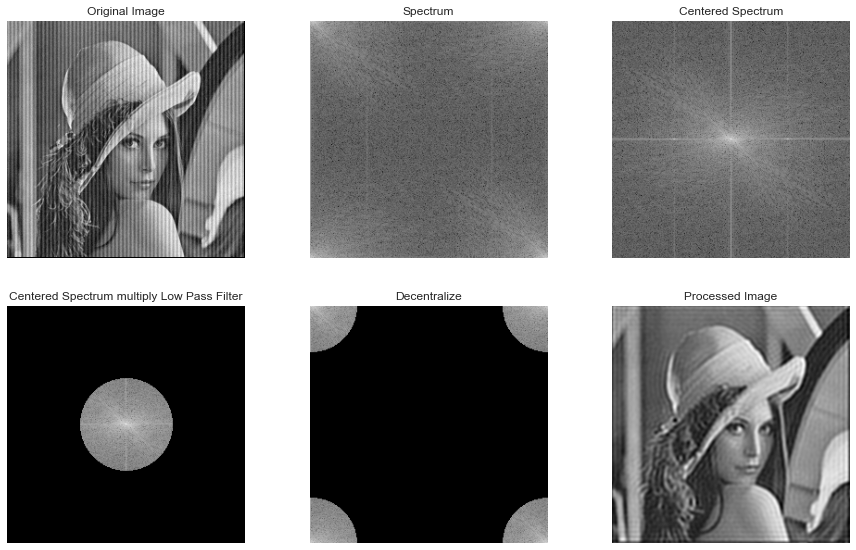

In [7]:
plt.figure(figsize=(6.4 * 2.4, 4.8 * 2), constrained_layout=False)


img = cv2.imread('img/lena_noise_image.png', 0)
plt.subplot(231), plt.imshow(img, 'gray'), plt.title('Original Image')
plt.axis('off')


original = np.fft.fft2(img)
plt.subplot(232), plt.imshow(np.log(1 + np.abs(original)), 'gray'), plt.title('Spectrum')
plt.axis('off')


center = np.fft.fftshift(original)
plt.subplot(233), plt.imshow(np.log(1 + np.abs(center)), 'gray'), plt.title('Centered Spectrum')
plt.axis('off')


LowPassCenter = center * idealFilterLP(50, img.shape)
plt.subplot(234), plt.imshow(np.log(1 + np.abs(LowPassCenter)), 'gray'), plt.title('Centered Spectrum multiply Low Pass Filter')
plt.axis('off')


LowPass = np.fft.ifftshift(LowPassCenter)
plt.subplot(235), plt.imshow(np.log(1 + np.abs(LowPass)), 'gray'), plt.title('Decentralize')
plt.axis('off')


inverse_LowPass = np.fft.ifft2(LowPass)
plt.subplot(236), plt.imshow(np.abs(inverse_LowPass), 'gray'), plt.title('Processed Image')
plt.axis('off')


plt.show()

### Фильтр высоких частот

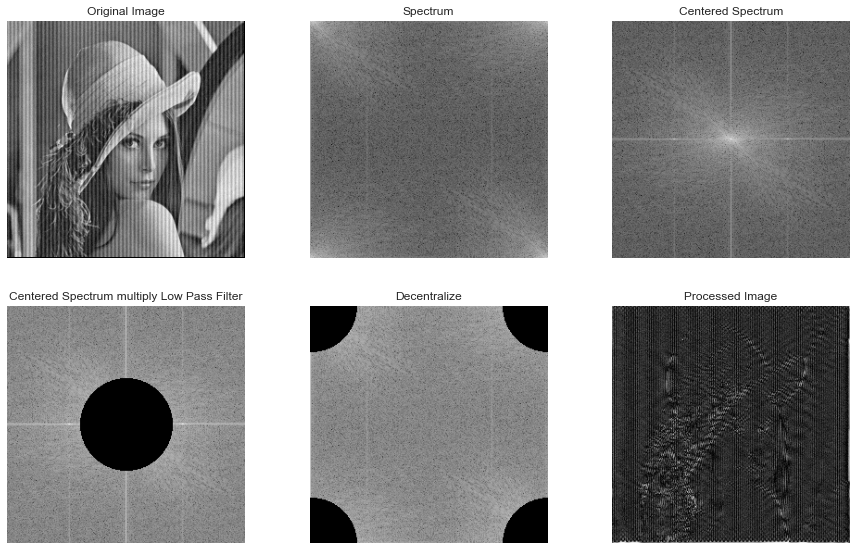

In [8]:
plt.figure(figsize=(6.4 * 2.4, 4.8 * 2), constrained_layout=False)


img = cv2.imread('img/lena_noise_image.png', 0)
plt.subplot(231), plt.imshow(img, 'gray'), plt.title('Original Image')
plt.axis('off')


original = np.fft.fft2(img)
plt.subplot(232), plt.imshow(np.log(1 + np.abs(original)), 'gray'), plt.title('Spectrum')
plt.axis('off')


center = np.fft.fftshift(original)
plt.subplot(233), plt.imshow(np.log(1 + np.abs(center)), 'gray'), plt.title('Centered Spectrum')
plt.axis('off')


LowPassCenter = center * idealFilterHP(50, img.shape)
plt.subplot(234), plt.imshow(np.log(1 + np.abs(LowPassCenter)), 'gray'), plt.title('Centered Spectrum multiply Low Pass Filter')
plt.axis('off')


LowPass = np.fft.ifftshift(LowPassCenter)
plt.subplot(235), plt.imshow(np.log(1 + np.abs(LowPass)), 'gray'), plt.title('Decentralize')
plt.axis('off')


inverse_LowPass = np.fft.ifft2(LowPass)
plt.subplot(236), plt.imshow(np.abs(inverse_LowPass), 'gray'), plt.title('Processed Image')
plt.axis('off')


plt.show()

## Butterworth Filter

В отличие от идеального фильтра, фильтр Баттерворта не имеет резких разрывов, что дает четкое разделение между проходной и отфильтрованной частотами. Фильтр Баттерворта вводит в функцию новый параметр $n$. При работе с $n$ он влияет на чистоту среза между переданной и отфильтрованной частотами.

<td> <img src="img/butterLP.png" alt="Drawing" style="width: 600px;"/> </td>

<td> <img src="img/butterHP.png" alt="Drawing" style="width: 600px;"/> </td>

In [9]:
def butterworthLP(D0, img_size, n):
    base = np.zeros(img_size[:2])
    rows, cols = img_size[:2]
    center = (rows / 2, cols / 2)
    
    for x in range(cols):
        for y in range(rows):
            base[y, x] = 1 / (1 + (distance((y, x), center) / D0) ** (2 * n))
            
    return base


def butterworthHP(D0, img_size, n):
    base = np.zeros(img_size[:2])
    rows, cols = img_size[:2]
    center = (rows / 2, cols / 2)
    
    for x in range(cols):
        for y in range(rows):
            base[y, x] = 1 - 1 / (1 + (distance((y, x), center) / D0) ** (2 * n))
            
    return base

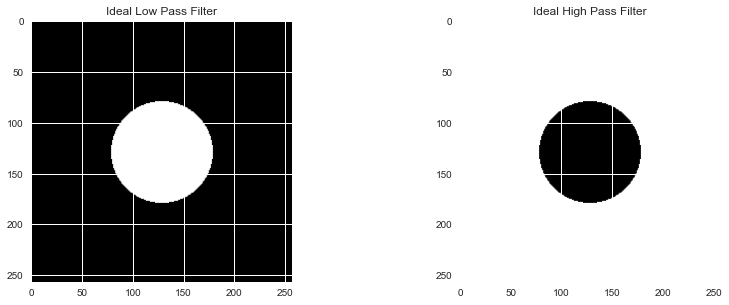

In [10]:
plt.figure(figsize=(6.4 * 2.2, 4.8 * 1), constrained_layout=False)

LowPass = idealFilterLP(50, img.shape)
plt.subplot(121), plt.imshow(LowPass, 'gray'), plt.title('Ideal Low Pass Filter')

HighPass = idealFilterHP(50, img.shape)
plt.subplot(122), plt.imshow(HighPass, 'gray'), plt.title('Ideal High Pass Filter')

plt.show()

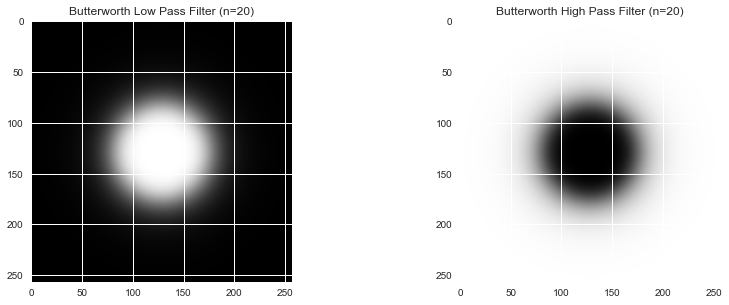

In [11]:
n = 3  # показатель размытия контура фильтра

plt.figure(figsize=(6.4 * 2.2, 4.8 * 1), constrained_layout=False)

LowPass = butterworthLP(50, img.shape, n)
plt.subplot(121), plt.imshow(LowPass, 'gray'), plt.title('Butterworth Low Pass Filter (n=20)')

HighPass = butterworthHP(50, img.shape, n)
plt.subplot(122), plt.imshow(HighPass, 'gray'), plt.title('Butterworth High Pass Filter (n=20)')

plt.show()

## Gaussian Filter

Гауссовский фильтр - более плавная версия, чем Баттерворт. Отсечение между переданной и отфильтрованной частотами очень размыто, что приводит к более гладкой обработке изображений.

<td> <img src="img/gaussLP.png" alt="Drawing" style="width: 600px;"/> </td>

<td> <img src="img/gaussHP.png" alt="Drawing" style="width: 600px;"/> </td>

In [12]:
def gaussianLP(D0, img_size):
    base = np.zeros(img_size[:2])
    rows, cols = img_size[:2]
    center = (rows / 2, cols / 2)
    
    for x in range(cols):
        for y in range(rows):
            base[y, x] = np.exp(((-distance((y, x), center) ** 2) / (2 * (D0 ** 2))))
            
    return base


def gaussianHP(D0, img_size):
    base = np.zeros(img_size[:2])
    rows, cols = img_size[:2]
    center = (rows / 2, cols / 2)
    
    for x in range(cols):
        for y in range(rows):
            base[y, x] = 1 - np.exp(((-distance((y, x), center) ** 2) / (2 * (D0 ** 2))))
            
    return base

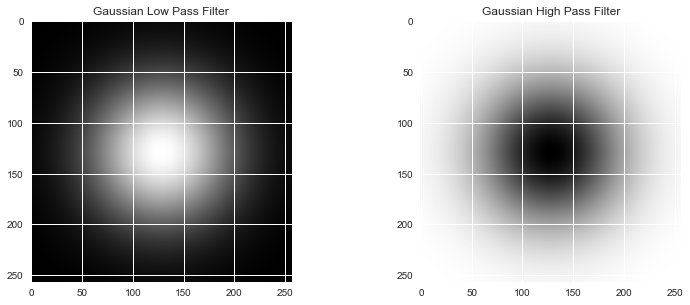

In [13]:
plt.figure(figsize=(6.4 * 2, 4.8 * 1), constrained_layout=False)

LowPass = gaussianLP(50, img.shape)
plt.subplot(121), plt.imshow(LowPass, 'gray'), plt.title('Gaussian Low Pass Filter')

HighPass = gaussianHP(50, img.shape)
plt.subplot(122), plt.imshow(HighPass, 'gray'), plt.title('Gaussian High Pass Filter')

plt.show()

## Качественное сравнение

### Только фильтры

Посмотрим сразу на все фильтры, рассмотренные ранее. 

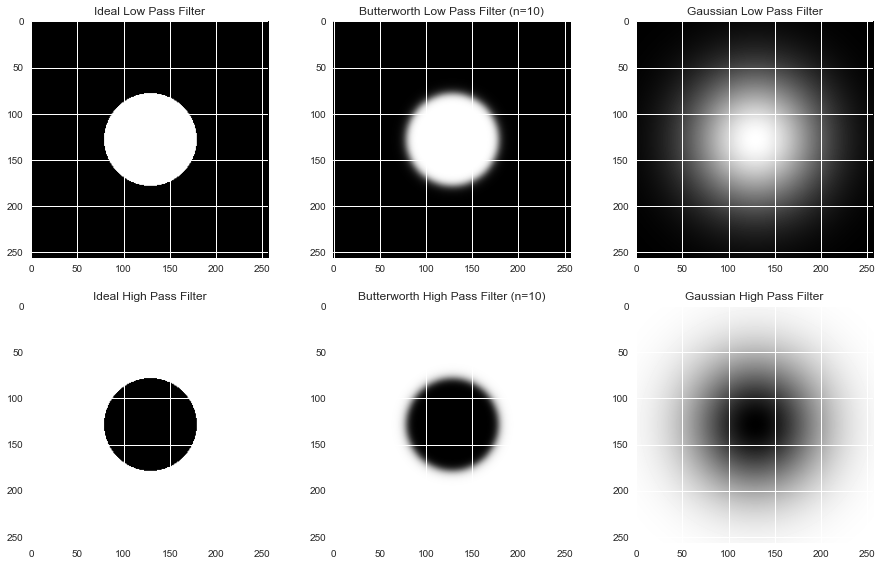

In [14]:
plt.figure(figsize=(6.4 * 2.4, 4.8 * 2), constrained_layout=False)


IdealLP = idealFilterLP(50, img.shape)
plt.subplot(231), plt.imshow(IdealLP, 'gray'), plt.title('Ideal Low Pass Filter')


ButterLP = butterworthLP(50, img.shape, 10)
plt.subplot(232), plt.imshow(ButterLP, 'gray'), plt.title('Butterworth Low Pass Filter (n=10)')


GaussianLP = gaussianLP(50, img.shape)
plt.subplot(233), plt.imshow(GaussianLP, 'gray'), plt.title('Gaussian Low Pass Filter')


IdealHP = idealFilterHP(50, img.shape)
plt.subplot(234), plt.imshow(IdealHP, 'gray'), plt.title('Ideal High Pass Filter')


ButterHP = butterworthHP(50, img.shape, 10)
plt.subplot(235), plt.imshow(ButterHP, 'gray'), plt.title('Butterworth High Pass Filter (n=10)')


GaussianHP = gaussianHP(50, img.shape)
plt.subplot(236), plt.imshow(GaussianHP, 'gray'), plt.title('Gaussian High Pass Filter')


plt.show()

### Фильтры на изображении

Теперь применим каждый из этих фильтров к исходному изображению и посмотрим на результат.

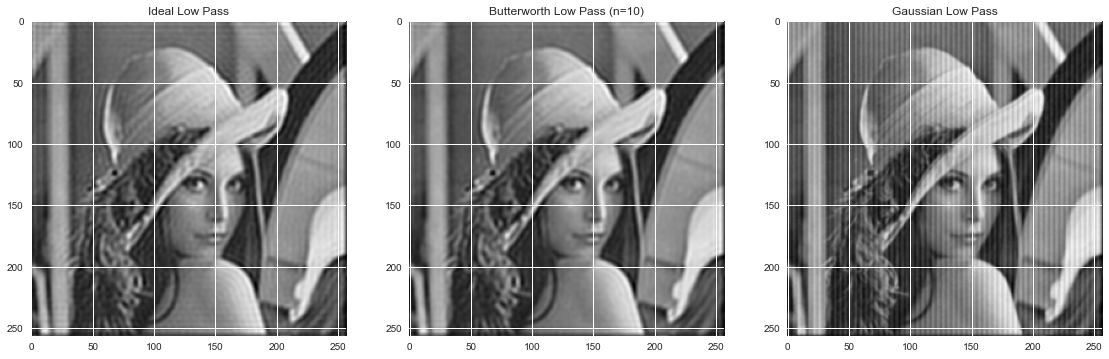

In [15]:
img = cv2.imread('img/lena_noise_image.png', 0)
original = np.fft.fft2(img)
center = np.fft.fftshift(original)

plt.figure(figsize=(6.4 * 3, 4.8 * 2), constrained_layout=False)

LowPassCenter = center * idealFilterLP(50, img.shape)
LowPass = np.fft.ifftshift(LowPassCenter)
inverse_LowPass = np.fft.ifft2(LowPass)
plt.subplot(131), plt.imshow(np.abs(inverse_LowPass), 'gray'), plt.title('Ideal Low Pass')


LowPassCenter = center * butterworthLP(50, img.shape, 10)
LowPass = np.fft.ifftshift(LowPassCenter)
inverse_LowPass = np.fft.ifft2(LowPass)
plt.subplot(132), plt.imshow(np.abs(inverse_LowPass), 'gray'), plt.title('Butterworth Low Pass (n=10)')


LowPassCenter = center * gaussianLP(50, img.shape)
LowPass = np.fft.ifftshift(LowPassCenter)
inverse_LowPass = np.fft.ifft2(LowPass)
plt.subplot(133), plt.imshow(np.abs(inverse_LowPass), 'gray'), plt.title('Gaussian Low Pass')


plt.show()

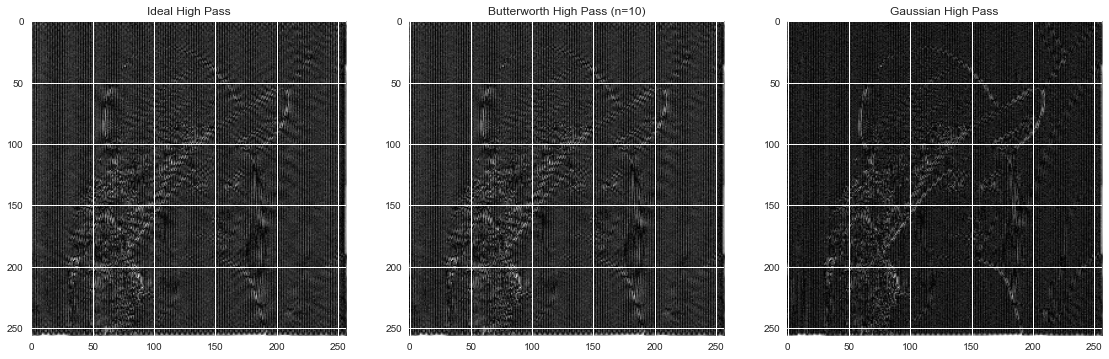

In [16]:
img = cv2.imread("img/lena_noise_image.png", 0)
original = np.fft.fft2(img)
center = np.fft.fftshift(original)

plt.figure(figsize=(6.4 * 3, 4.8 * 2), constrained_layout=False)

HighPassCenter = center * idealFilterHP(50, img.shape)
HighPass = np.fft.ifftshift(HighPassCenter)
inverse_HighPass = np.fft.ifft2(HighPass)
plt.subplot(131), plt.imshow(np.abs(inverse_HighPass), 'gray'), plt.title('Ideal High Pass')

HighPassCenter = center * butterworthHP(50, img.shape, 10)
HighPass = np.fft.ifftshift(HighPassCenter)
inverse_HighPass = np.fft.ifft2(HighPass)
plt.subplot(132), plt.imshow(np.abs(inverse_HighPass), 'gray'), plt.title('Butterworth High Pass (n=10)')

HighPassCenter = center * gaussianHP(50,img.shape)
HighPass = np.fft.ifftshift(HighPassCenter)
inverse_HighPass = np.fft.ifft2(HighPass)
plt.subplot(133), plt.imshow(np.abs(inverse_HighPass), 'gray'), plt.title('Gaussian High Pass')

plt.show()

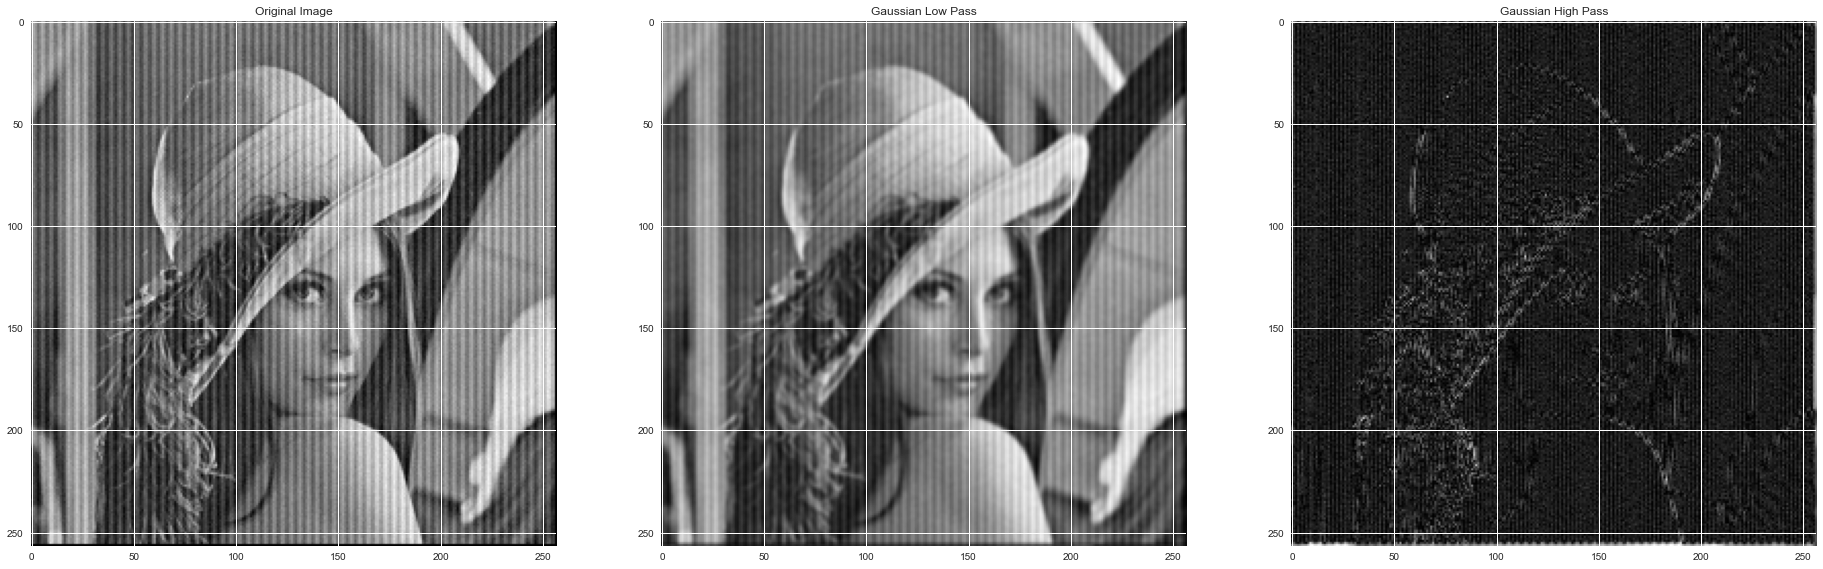

In [17]:
img = cv2.imread("img/lena_noise_image.png", 0)
original = np.fft.fft2(img)
center = np.fft.fftshift(original)

plt.figure(figsize=(6.4*5, 4.8*5), constrained_layout=False)

plt.subplot(131), plt.imshow(img, "gray"), plt.title("Original Image")

LowPassCenter = center * gaussianLP(50,img.shape)
LowPass = np.fft.ifftshift(LowPassCenter)
inverse_LowPass = np.fft.ifft2(LowPass)
plt.subplot(132), plt.imshow(np.abs(inverse_LowPass), "gray"), plt.title("Gaussian Low Pass")

HighPassCenter = center * gaussianHP(50,img.shape)
HighPass = np.fft.ifftshift(HighPassCenter)
inverse_HighPass = np.fft.ifft2(HighPass)
plt.subplot(133), plt.imshow(np.abs(inverse_HighPass), "gray"), plt.title("Gaussian High Pass")

plt.show()

# Свертки

## Основы сверток
**Свертки** $-$ это метод общей обработки сигналов. Люди, изучающие электронику, скажут вам о почти бесконечных бессонных ночах, которые были потрачены на их постижение. На эту тему написано множество книг. Но для компьютерного зрения мы просто разберемся с некоторыми простыми вещами.

## Определение
Во-первых, давайте посмотрим на математическое определение свертки в дискретной области времени. Позже мы пройдемся по тому, что говорит нам это уравнение.
${\begin{align}y[n]&=x[n]*h[n]=\sum_{k=-\infty}^\infty x[k]\cdot h[n-k]\end{align},}$

где:
* **x[n]** $-$ входой сигнал;
* **h[n]** $-$ импульсный отклик; 
* **y[n]** $-$ выходной сигнал;
* **$*$** $-$ обозначает свертку. 

Обратите внимание, что мы умножаем слагаемые $x[k]$ на смещенные по времени $h[n]$ и складываем их.
Краеугольный камень понимания свертки лежит в основе импульсного отклика и импульсного разложения.

## Разложение импульсной функции

Чтобы понять смысл свертки, мы собираемся начать с концепции разложения сигналов. Входной сигнал разлагается на простые аддитивные компоненты, и системный отклик входного сигнала приводит к сложению выходных данных этих компонентов, прошедших через систему.

В общем, сигнал может быть разложен как взвешенная сумма базовых сигналов. Например, в рядах Фурье любой периодический сигнал (даже прямоугольный импульсный сигнал) может быть представлен суммой функций синуса и косинуса. Но здесь мы используем импульсные (дельта) функции для базовых сигналов, а не синус и косинус.

Изучим следующий пример того, как сигнал разлагается на набор импульсных (дельта) функций:
<img src="img/conv_img01.png" alt="Drawing" style="width: 200px;"/> 

Импульсная функция выглядит так: ${\delta(n)={\begin{cases}1, n=0\\ 0, n\ne0 \end{cases}}}$.  Тогда для данного примера $x[0]$ можно записать в виде ${x[0] = x[0] \cdot \delta[n-0] = 2 \cdot \delta[n-0]}$. Тогда $x[1]$ будет равен ${x[1] = x[1] \cdot \delta[n-1] = 3 \cdot \delta[n-1]}$, потому что ${\delta[n-1]}$ равна $1$ при $n = 1$ и ноль в других случаях. Таким же образом мы можем записать ${x[2] = x[2] \cdot \delta[n-2] = 1 \cdot \delta[n-2]}$, сдвинув ${\delta[n]}$ на 2. Следовательно, сигнал $x[n]$ может быть представлен добавлением $3$ сдвинутых и масштабированных импульсных функций.

В общем, сигнал может быть записан как сумма масштабированных и сдвинутых дельта-функций:
${\begin{align}x[n]=\sum_{k=0}^2 x[k]\cdot\delta[n-k]=x[0]\cdot\delta[n-0]+x[1]\cdot\delta[n-1]+x[2]\cdot\delta[n-2]\end{align}}$

## Импульсивный отклик
**Импульсный отклик** $-$ это выход системы, являющийся результатом импульсной функции в качестве входа.
Именно это обозначается за $h[n]$. Все волшебство именно тут. Для вас это перестанет быть магией на 2-3 курсе инстиута. 

Существует огромное множество преобразования для импульсного отклика. Мы рассмотрим только конечные формулы без понимания того, как работает математика.

<td> <img src="img/conv_img02.png" alt="Drawing" style="width: 400px;"/> </td>

## Свертка в 2D
2D свертка является просто продолжением предыдущей 1D свертки путем свертки как горизонтального, так и вертикального направлений в двухмерной пространственной области. Свертка часто используется для обработки изображений, таких как сглаживание, повышение резкости и обнаружение краев изображений.

Импульсная (дельта) функция также находится в двумерном пространстве, поэтому ${\delta[m,n]={\begin{cases}1,\ m=n=0\\0,\ m\ne0,n\ne0\end{cases}}}$. Импульсный отклик в 2D обычно называют **«ядром»** или **«фильтром»** в обработке изображений.

<table><tr>
    <td> <img src="img/conv2d_delta.jpg" alt="Drawing" style="width: 300px;"/> </td>
    <td> <img src="img/conv_img10.png" alt="Drawing" style="width: 200px;"/> </td>
</tr></table>

Кроме того, выходные данные линейной и инвариантной по времени системы могут быть записаны путем свертки входного сигнала $x[m,n]$ и импульсной характеристики $h[m,n]$:
${\begin{align}y[m,n]=x[m,n]*h[m,n]=\sum_{j=-\infty}^\infty \sum_{i=-\infty}^\infty x[i,j]\cdot h[m-i,n-j]\end{align}}$

Изучим пример, чтобы уточнить, как работает свертка в **2D**-пространстве.
Допустим, что размер импульсного отклика (ядра) составляет $3\times3$, а его значения **a, b, c, d, ...**

Обратите внимание, что начало координат $(0,0)$ находится в центре ядра.

Давайте выберем простейший пример и вычислим свертку, например, результат в $(1,1)$:
<img src="img/conv_img11.png" alt="Drawing" style="width: 200px;"/>
${\begin{align}
y[1,1] & = \sum_{j=0}^2 \sum_{i=0}^2 x[i,j] \cdot h[1-i,1-j]  \\ &
= x[0,0] \cdot h[1,1] + x[1,0] \cdot h[0,1] + x[2,0] \cdot h[-1,1] \\ &
+ x[0,1] \cdot h[1,0] + x[1,1] \cdot h[0,0] + x[2,1] \cdot h[-1,0] \\ &
+ x[0,2] \cdot h[1,-1] + x[1,2] \cdot h[0,-1] + x[2,2] \cdot h[-1,-1]
\end{align}}$

Рассмотрим более конкртеный пример с двумерной сверткой. Предположим, у нас есть входные матрицы $3\times3$ и ядра $3\times3$ следующим образом:

Input | Kernel | Output
-|-|-
<img src="img/conv_img15.png" alt="Drawing" style="width: 200px;"/> | <img src="img/conv_img16.png" alt="Drawing" style="width: 200px;"/> | <img src="img/conv_img17.png" alt="Drawing" style="width: 200px;"/>
Выходной сигнал в точке $(1,1)$ для этого примера будет:
${\begin{align}
\ y[1,1] & = \sum_{j=0}^2 \sum_{i=0}^2 x[i,j] \cdot h[1-i,1-j]  \\ &
\ = x[0,0] \cdot h[1,1] + x[1,0] \cdot h[0,1] + x[2,0] \cdot h[-1,1] \\ &
\ + x[0,1] \cdot h[1,0] + x[1,1] \cdot h[0,0] + x[2,1] \cdot h[-1,0] \\ &
\ + x[0,2] \cdot h[1,-1] + x[1,2] \cdot h[0,-1] + x[2,2] \cdot h[-1,-1] \\&
\ = 1 \cdot 1 + 2 \cdot 2 + 3 \cdot 1 \\ &
\ + 4 \cdot 0 + 5 \cdot 0 + 6 \cdot 0 \\ &
\ + 7 \cdot (-1) + 8 \cdot (-2) + 9 \cdot (-1) \\ &
\ = -24 \\
\end{align}}$

## Визуализация применения сверток

_N.B.: Blue maps are inputs, and cyan maps are outputs._

<table style="width:100%; table-layout:fixed;">
  <tr>
    <td><img width="150px" src="img/gif/no_padding_no_strides.gif"></td>
    <td><img width="150px" src="img/gif/arbitrary_padding_no_strides.gif"></td>
    <td><img width="150px" src="img/gif/same_padding_no_strides.gif"></td>
    <td><img width="150px" src="img/gif/full_padding_no_strides.gif"></td>
  </tr>
  <tr>
    <td>No padding, no strides</td>
    <td>Arbitrary padding, no strides</td>
    <td>Half padding, no strides</td>
    <td>Full padding, no strides</td>
  </tr>
  <tr>
    <td><img width="150px" src="img/gif/no_padding_strides.gif"></td>
    <td><img width="150px" src="img/gif/padding_strides.gif"></td>
    <td><img width="150px" src="img/gif/padding_strides_odd.gif"></td>
    <td></td>
  </tr>
  <tr>
    <td>No padding, strides</td>
    <td>Padding, strides</td>
    <td>Padding, strides (odd)</td>
    <td></td>
  </tr>
</table>

## Transposed convolution animations

_N.B.: Blue maps are inputs, and cyan maps are outputs._

<table style="width:100%; table-layout:fixed;">
  <tr>
    <td><img width="150px" src="img/gif/no_padding_no_strides_transposed.gif"></td>
    <td><img width="150px" src="img/gif/arbitrary_padding_no_strides_transposed.gif"></td>
    <td><img width="150px" src="img/gif/same_padding_no_strides_transposed.gif"></td>
    <td><img width="150px" src="img/gif/full_padding_no_strides_transposed.gif"></td>
  </tr>
  <tr>
    <td>No padding, no strides, transposed</td>
    <td>Arbitrary padding, no strides, transposed</td>
    <td>Half padding, no strides, transposed</td>
    <td>Full padding, no strides, transposed</td>
  </tr>
  <tr>
    <td><img width="150px" src="img/gif/no_padding_strides_transposed.gif"></td>
    <td><img width="150px" src="img/gif/padding_strides_transposed.gif"></td>
    <td><img width="150px" src="img/gif/padding_strides_odd_transposed.gif"></td>
    <td></td>
  </tr>
  <tr>
    <td>No padding, strides, transposed</td>
    <td>Padding, strides, transposed</td>
    <td>Padding, strides, transposed (odd)</td>
    <td></td>
  </tr>
</table>

## Dilated convolution animations

_N.B.: Blue maps are inputs, and cyan maps are outputs._

<table style="width:25%"; table-layout:fixed;>
  <tr>
    <td><img width="150px" src="img/gif/dilation.gif"></td>
  </tr>
  <tr>
    <td>No padding, no stride, dilation</td>
  </tr>
</table>

*Источник: https://github.com/vdumoulin/conv_arithmetic*


## 2D Свертки в OpenCV (Фильтрация изображений)

Как и в одномерных сигналах, изображения также могут быть отфильтрованы с помощью различных низкочастотных фильтров (LPF), высокочастотных фильтров (HPF) и т.д. 
**LPF** помогает удалять шумы, размывать изображения. Фильтры **HPF** помогают находить края в изображений.

**OpenCV** предоставляет функцию **cv2.filter2D()** для объединения ядра с изображением. В качестве примера мы попробуем усредняющий фильтр на изображении. Ядро усредняющего фильтра $5\times5$ будет выглядеть так:

${\begin{equation*}
\ K = \frac{1}{25} \begin{pmatrix}
1 & \ 1 & \ 1 & \ 1 & \ 1 \\
1 & \ 1 & \ 1 & \ 1 & \ 1 \\
1 & \ 1 & \ 1 & \ 1 & \ 1 \\
1 & \ 1 & \ 1 & \ 1 & \ 1 \\
1 & \ 1 & \ 1 & \ 1 & \ 1 
\end{pmatrix}
\end{equation*}}$

Свертка выполняется согласно теоретическим примерам выше. Как результат мы получаем осредненные пиксели своими 25 соседями.

In [18]:
img = cv2.imread('img/8_ka.jpg')

# для отрисовки в pyplot
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

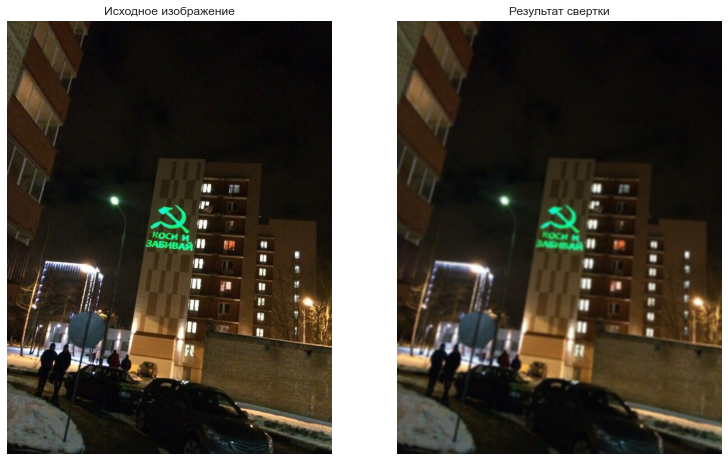

In [19]:
kernel = np.ones((5, 5), dtype=np.float32)
kernel /= np.sum(kernel)
dst = cv2.filter2D(img.copy(), -1, kernel)


plt.figure(figsize=(6.4 * 2,  4.8 * 3))

plt.subplot(121), plt.imshow(img), plt.title('Исходное изображение'), plt.axis('off')
plt.subplot(122), plt.imshow(dst), plt.title('Результат свертки'), plt.axis('off')

plt.show()

# Фильтрация изображения

Размытие изображения достигается путем свертывания изображения с помощью фильтра нижних частот. Это полезно для удаления шумов. Это фактически удаляет высокочастотный контент (например: шум, края) с изображения. Таким образом, края в этой операции немного размыты. (Ну, есть методы размытия, которые тоже не размывают края). **OpenCV** предоставляет в основном четыре типа техники размытия.

Более подробное описание реализации фильтров OpenCV есть в [документации](https://docs.opencv.org/3.4.2/d4/d86/group__imgproc__filter.html).

## Усреднение

Это делается путем свертки изображения с помощью нормализованного прямоугольного фильтра. Он просто берет среднее значение всех пикселей в области ядра и заменяет центральный элемент. Это выполняется функцией **cv2.blur()** или **cv2.boxFilter()**. Для более подробной информации о ядре посмотрите в документации. Мы должны указать ширину и высоту ядра. Нормализованный блочный фильтр $3\times3$ будет выглядеть следующим образом:

${\begin{equation*}K = \frac{1}{9} 
{\begin{pmatrix}
1 & \ 1 & \ 1 \\ 
1 & \ 1 & \ 1 \\ 
1 & \ 1 & \ 1 \end{pmatrix}}
\end{equation*}}$

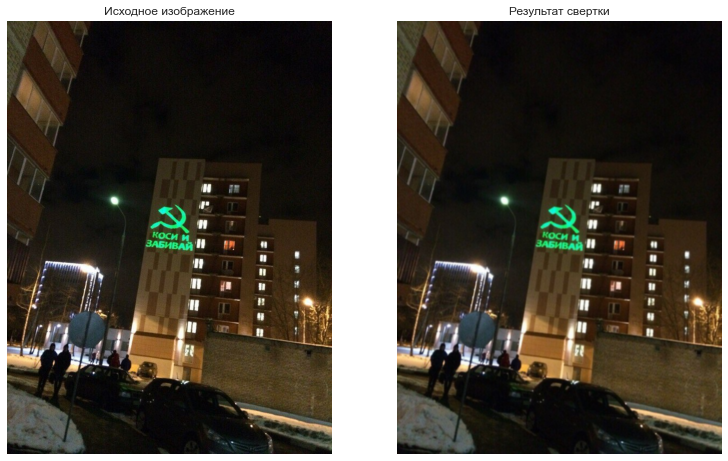

In [20]:
blur = cv2.blur(img.copy(), (3, 3))

plt.figure(figsize=(6.4 * 2,  4.8 * 3))

plt.subplot(121), plt.imshow(img), plt.title('Исходное изображение'), plt.axis('off')
plt.subplot(122), plt.imshow(blur), plt.title('Результат свертки'), plt.axis('off')

plt.show()

## Размытие по Гауссу

При этом вместо box filter используется ядро Гаусса. Это делается с помощью функции **cv2.GaussianBlur()**. Мы должны указать ширину и высоту ядра, которые должны быть положительными и нечетными. Мы также должны указать стандартное отклонение в направлениях **X** и **Y**, **sigmaX** и **sigmaY** соответственно. Если указан только **sigmaX**, то **sigmaY** принимается так же, как **sigmaX**. Если оба даны в виде нулей, они рассчитываются по размеру ядра. Размытие по Гауссу очень эффективно для удаления гауссовского шума с изображения.

Если вы хотите, вы можете создать ядро Гаусса с помощью функции **cv2.getGaussianKernel()**, а затем применить его с помощью **cv2.filter2D()**.

### Гауссово окно

Гауссова функция (гауссиан, гауссиана, функция Гаусса) — вещественная функция, описываемая следующей формулой:

${\displaystyle g\left(x\right)=a*exp{-{\frac {(x-b)^{2}}{2c^{2}}}}}$

Эта функция имеет широкое приминение в математической статистике. В таком случае параметры выражаются через среднеквадратичное отклонение ${\displaystyle \sigma }$ и математическое ожидание ${\displaystyle \mu }$ :

${\displaystyle a={\frac {1}{\sigma {\sqrt {2\pi }}}}}, {\displaystyle b=\mu }, {\displaystyle c=\sigma }$

В двумерном виде она имеет такое представление:

${\displaystyle g(x,y)=A\cdot exp{\left(-\left({\frac {(x-x_{0})^{2}}{2\sigma _{x}^{2}}}+{\frac {(y-y_{0})^{2}}{2\sigma _{y}^{2}}}\right)\right)}}$

Стандартным статистическим способом мы определили ширину гауссовой формы в терминах $\sigma$. Тем не менее, когда для сглаживания используется гауссиан, для сканеров характерно описывать ширину гауссиана с помощью другой связанной меры - полной ширины на половине максимума (FWHM).

FWHM - ширина ядра, равная половине максимума высоты гауссианы.

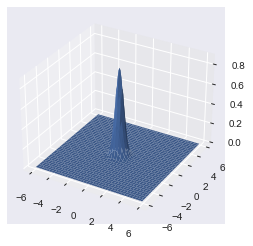

In [21]:
from mpl_toolkits.mplot3d import Axes3D

def fwhm2sigma(fwhm):
    return fwhm / np.sqrt(8 * np.log(2))


FWHM = 1
sigma = fwhm2sigma(FWHM)


dx = 0.1
dy = 0.1
x = np.arange(-6, 6, dx)
y = np.arange(-6, 6, dy)
x2d, y2d = np.meshgrid(x, y)
kernel_2d = np.exp(-(x2d ** 2 + y2d ** 2) / (2 * sigma ** 2))
kernel_2d = kernel_2d / (2 * np.pi * sigma ** 2)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x2d, y2d, kernel_2d)
plt.show()

Таким образом, можно представить, что окно гаусса представляет из себя проекцию функции на плоскость. Проиллюстрировано на картинке:

<img src="img/gaus_win.png" alt="Drawing" style="width: 300px;"/> 

Собственно, теперь перейдем к __threshold__.

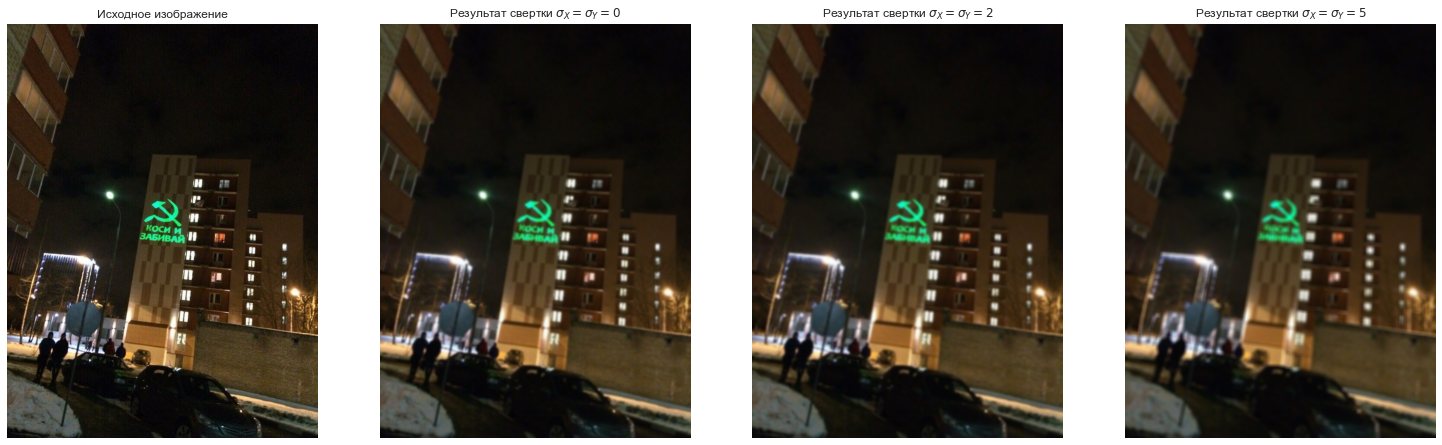

In [22]:
## Код для размытия по Гауссу: 
blur1 = cv2.GaussianBlur(img.copy(), (9,9), 0)
blur2 = cv2.GaussianBlur(img.copy(), (9,9), 2)
blur3 = cv2.GaussianBlur(img.copy(), (9,9), 5)


plt.figure(figsize=(6.4 * 4,  4.8 * 2))

plt.subplot(141), plt.imshow(img), plt.title('Исходное изображение'), plt.axis('off')
plt.subplot(142), plt.imshow(blur1), plt.title(r'Результат свертки $\sigma_X = \sigma_Y = 0$'), plt.axis('off')
plt.subplot(143), plt.imshow(blur2), plt.title(r'Результат свертки $\sigma_X = \sigma_Y = 2$'), plt.axis('off')
plt.subplot(144), plt.imshow(blur3), plt.title(r'Результат свертки $\sigma_X = \sigma_Y = 5$'), plt.axis('off')

plt.show()

## Среднее размытие

Здесь функция **cv2.medianBlur()** принимает медиану всех пикселей в области ядра, и центральный элемент заменяется этим медианным значением. Это очень эффективно против шума соли и перца на изображениях. Интересно, что в вышеупомянутых фильтрах центральным элементом является вновь вычисленное значение, которое может быть значением пикселя в изображении или новым значением. Но при медианном размытии центральный элемент всегда заменяется некоторым пиксельным значением на изображении. 

Эффективно снижает шум. Размер его ядра должен быть положительным нечетным целым числом.

В этой демонстрации я добавил шум к нашему исходному изображению и применил медианное размытие. Проверьте результат:

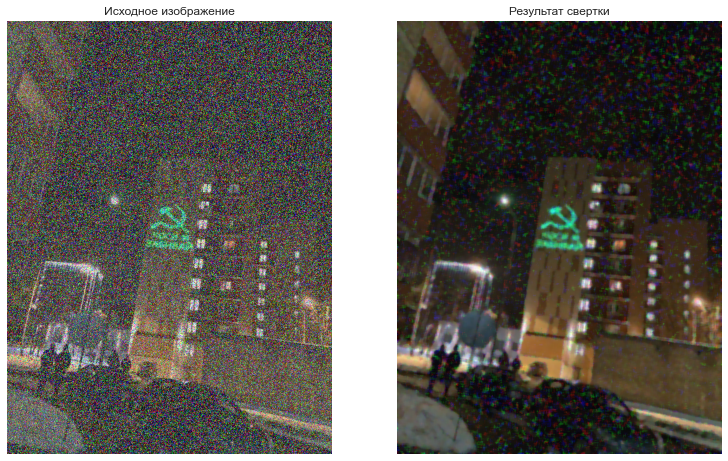

In [23]:
# внесем шум
noise_img = img.copy()
mask = np.random.randint(0, 2, size=noise_img.shape).astype(bool)
r = np.random.rand(*noise_img.shape) * np.max(noise_img)
noise_img[mask] = r[mask]

median = cv2.medianBlur(noise_img, 7)


plt.figure(figsize=(6.4 * 2,  4.8 * 3))

plt.subplot(121), plt.imshow(noise_img), plt.title('Исходное изображение'), plt.axis('off')
plt.subplot(122), plt.imshow(median), plt.title('Результат свертки'), plt.axis('off')

plt.show()

## Двусторонняя фильтрация

**cv2.bilateralFilter()** очень эффективно удаляет шум, сохраняя края острыми. Но операция медленнее по сравнению с другими фильтрами. Мы уже видели, что фильтр Гаусса берет окрестность вокруг пикселя и находит его средневзвешенное значение по Гауссу. Этот гауссов фильтр является функцией только одного пространства, то есть при фильтрации учитываются соседние пиксели. Он не учитывает, имеют ли пиксели почти одинаковую интенсивность. Он не учитывает, является ли пиксель краевым или нет. Таким образом, это стирает края, что мы не хотим делать.

Двусторонний фильтр также принимает гауссов фильтр в пространстве, но еще один гауссов фильтр, который является функцией разности пикселей. Гауссова функция пространства обеспечивает размытие только соседних пикселей, а гауссова функция разности интенсивности - размытие только тех пикселей, интенсивность которых равна центральной. Таким образом, он сохраняет края, поскольку пиксели на краях будут сильно изменяться.

**Рекомендации к фильтру:**

* **Sigma values:** для простоты вы можете установить два значения сигмы одинаковыми. Если они маленькие ($<10$), фильтр не будет иметь большого эффекта, тогда как если они большие ($>150$), они будут иметь очень сильный эффект, делая изображение размытым.

* **Размер фильтра:** Большие фильтры (d$>5$) очень медленные, поэтому рекомендуется использовать d $=5$ для приложений реального времени и, возможно, d $=9$ для автономных приложений, которые нуждаются в сильной фильтрации шума.

Ниже приведены примеры использования двустороннего фильтра.

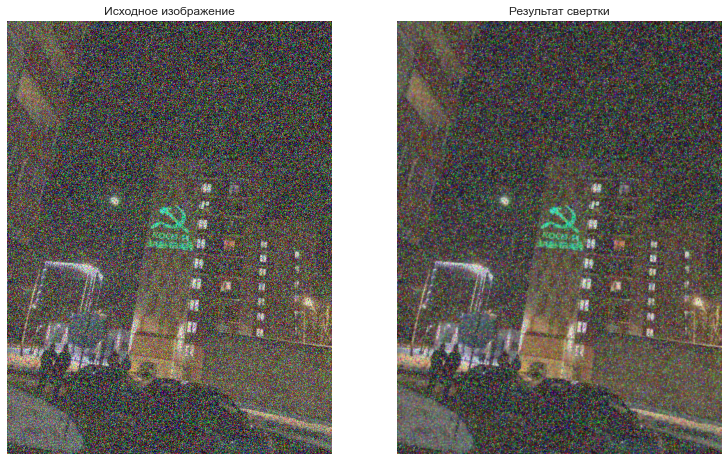

In [24]:
# внесем шум
noise_img = img.copy()
mask = np.random.randint(0, 2, size=noise_img.shape).astype(bool)
r = np.random.rand(*noise_img.shape) * np.max(noise_img)
noise_img[mask] = r[mask]

bilateral = cv2.bilateralFilter(noise_img, d=5, sigmaColor=150, sigmaSpace=250)


plt.figure(figsize=(6.4 * 2,  4.8 * 3))

plt.subplot(121), plt.imshow(noise_img), plt.title('Исходное изображение'), plt.axis('off')
plt.subplot(122), plt.imshow(bilateral), plt.title('Результат свертки'), plt.axis('off')

plt.show()

## Элайзинг изображений

Размытие по Гауссу обычно используется при уменьшении размера изображения. При понижающей дискретизации изображения обычно применяют фильтр низких частот к изображению перед повторной дискретизацией. Это делается для того, чтобы ложная высокочастотная информация не появлялась на изображении с пониженной дискретизацией (aliasing). Гауссовские размытия имеют хорошие свойства, такие как отсутствие острых краев. 

Проясним на примере:
<table style="width:55%"; table-layout:fixed;>
  <tr>
    <td><img src="img/alising_nan.jpg" alt="Drawing" style="width: 500px;"/> </td>
    <td><img src="img/alising.jpg" alt="Drawing" style="width: 500px;"/> </td>
  </tr>
  <tr>
    <td>Изображение без сжатия</td>
    <td>Эффект alising от сжатия</td>
  </tr>
</table>

# **Кросс-корреляция**

Допустим, есть два изображения, которые выглядят похожими, но слегка смещены. Мы можем оценить, насколько и в каком направлении смещены изображения, сравнивая их преобразования Фурье.

<img src="img/shifted_spectrum.png" alt="Drawing" style="width: 500px;"/> 

Эта техника может быть использована для стабилизации видео на уже снятых видео. Как только мы узнали, насколько сильно смещаются два последовательных кадра видео, мы можем искусственно сдвинуть второй кадр так, чтобы он больше не смещался.

OpenCV реализует совпадение шаблонов в функции matchTemplate. Доступные методы 6:

**method=CV_TM_SQDIFF**

$R(x,y)= \sum _{x',y'} (T(x',y')-I(x+x',y+y'))^2$

**method=CV_TM_SQDIFF_NORMED**

$R(x,y)= \frac{\sum_{x',y'} (T(x',y')-I(x+x',y+y'))^2}{\sqrt{\sum_{x',y'}T(x',y')^2 \cdot \sum_{x',y'} I(x+x',y+y')^2}}$

**method=CV_TM_CCORR**

$R(x,y)= \sum _{x',y'} (T(x',y')  \cdot I(x+x',y+y'))$

**method=CV_TM_CCORR_NORMED**

$R(x,y)= \frac{\sum_{x',y'} (T(x',y') \cdot I(x+x',y+y'))}{\sqrt{\sum_{x',y'}T(x',y')^2 \cdot \sum_{x',y'} I(x+x',y+y')^2}}$

**method=CV_TM_CCOEFF**

$R(x,y)= \sum _{x',y'} (T'(x',y')  \cdot I(x+x',y+y'))$

где

$\begin{array}{l} T'(x',y')=T(x',y') - 1/(w  \cdot h)  \cdot \sum _{x'',y''} T(x'',y'') \\ I'(x+x',y+y')=I(x+x',y+y') - 1/(w  \cdot h)  \cdot \sum _{x'',y''} I(x+x'',y+y'') \end{array}$

**thod=CV_TM_CCOEFF_NORMED**

$R(x,y)= \frac{ \sum_{x',y'} (T'(x',y') \cdot I'(x+x',y+y')) }{ \sqrt{\sum_{x',y'}T'(x',y')^2 \cdot \sum_{x',y'} I'(x+x',y+y')^2} }$

In [25]:
img_rgb = cv2.imread('img/mario_world.jpg')
img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

template = cv2.imread('img/mario_coin.jpg', 0)
w, h = template.shape[::-1]

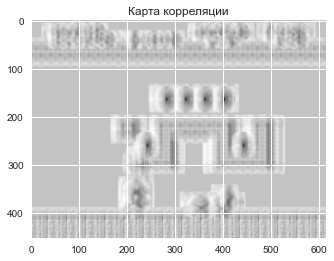

In [26]:
res = cv2.matchTemplate(img_gray, template, cv2.TM_CCOEFF_NORMED)  # коррелция по шаблону

# визуализация корреляции
plt.imshow(res)
plt.title('Карта корреляции')
plt.show()

In [27]:
# найдем по порогу самое больше значение корреляции
threshold = 0.8
loc = np.where(res >= threshold)

# отобразим результаты на шаблоне
for pt in zip(*loc[::-1]):
    cv2.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0,0,255), 3)

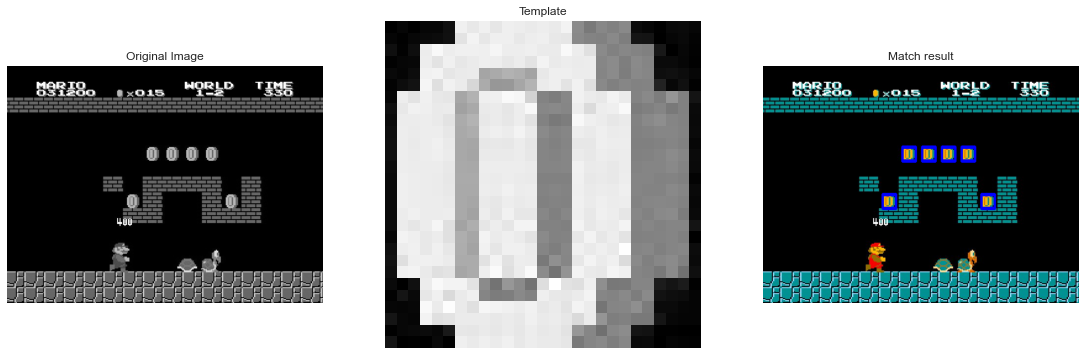

In [28]:
plt.figure(figsize=(6.4 * 3, 4.8 * 3), constrained_layout=False)

plt.subplot(131), plt.imshow(img_gray, cmap='gray'), plt.title("Original Image"), plt.axis('off')
plt.subplot(132), plt.imshow(template, cmap='gray'), plt.title("Template"), plt.axis('off')
plt.subplot(133), plt.imshow(img_rgb), plt.title("Match result"), plt.axis('off')
plt.show()

## Phase correlation

Использование преобразования Фурье не ограничивается фильтрацией. Если мы берем преобразование Фурье из двух последовательных кадров в видео, мы можем извлечь движение кадров. Это движение может быть использовано для коррекции дрожания камеры. Мы рассмотрим его фоновую математику и ее практическое применение в следующих постах. Этот алгоритм называется "Фазовая корреляция".

<img src="img/phase_correlation.png" alt="Drawing" style="width: 600px;"/> 

Алгоритм фазовой корреляции в основном заключается в том, чтобы просто взять преобразование Фурье двух изображений, а затем выполнить по ним некоторое вычисление:

$R = \frac{ \mathbf{G}_a \circ \mathbf{G}_b^*}{|\mathbf{G}_a \circ \mathbf{G}_b^*|}$, где $\ \mathbf{G}_a = \mathcal{F}\{g_a\}, \; \mathbf{G}_b = \mathcal{F}\{g_b\}$

Сначала мы сделаем преобразование Фурье из двух изображений масштаба серого 1 и 2. Мы ожидаем, что эти изображения будут двумя последовательными кадрами в видео, снятом дрожащей камерой.

In [29]:
image1_filename = 'img/img1.jpg'
image2_filename = 'img/img2.jpg'

image1 = cv2.imread(image1_filename, 0)
image2 = cv2.imread(image2_filename, 0)

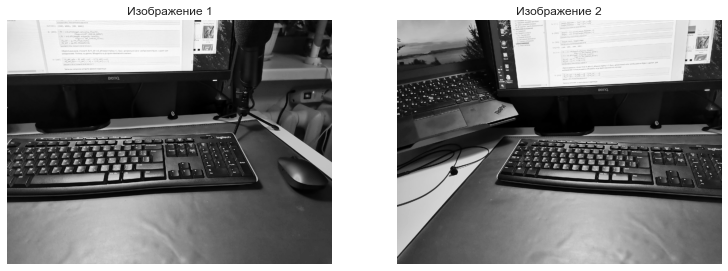

In [30]:
plt.figure(figsize=(6.4 * 2, 4.8 * 2), constrained_layout=False)
plt.subplot(121), plt.imshow(image1, cmap='gray'), plt.title('Изображение 1'), plt.axis('off')
plt.subplot(122), plt.imshow(image2, cmap='gray'), plt.title('Изображение 2'), plt.axis('off')
plt.show()

In [31]:
f1 = np.fft.fft2(image1)
f1 = np.fft.fftshift(f1)

f2 = np.fft.fft2(image2)
f2 = np.fft.fftshift(f2)
f2 = np.conjugate(f2)

Затем мы запускаем алгоритм фазовой корреляции:

In [32]:
P_complex = f1 * f2 / np.abs(f1 * f2)

Наконец, мы применяем обратное преобразование Фурье к ```P_complex```. В результате получается реальное изображение, почти черное, но имеющее только один сияющий белый пиксель. Расположение пикселя говорит о том, насколько сильно сместились два кадра.

$r = \mathcal{F}^{-1}\{R\}$

Общее местоположение получается индексы макимума в фазовой корреляции:

$(\Delta x, \Delta y) = \arg \max_{(x, y)}\{r\}$

In [33]:
P_inverse = np.fft.ifftshift(P_complex)
P_inverse = np.fft.ifft2(P_inverse)

# найдем пик 
idx = np.unravel_index(np.argmax(P_inverse.real), P_inverse.shape)

h, w = P_inverse.shape[:2]

shift_y = h - idx[0]
shift_x = w - idx[1]

Затем мы компенсируем сдвиг, основанный на этих предсказаниях. 

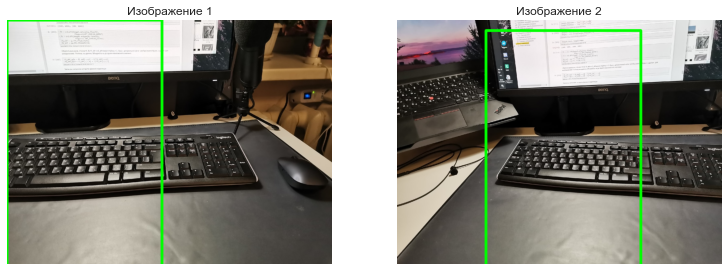

In [34]:
image1_rgb = cv2.imread(image1_filename)
image1_rgb = cv2.cvtColor(image1_rgb, cv2.COLOR_BGR2RGB)
image2_rgb = cv2.imread(image2_filename)
image2_rgb = cv2.cvtColor(image2_rgb, cv2.COLOR_BGR2RGB)

# отобразим общую область на двух изображениях
cv2.rectangle(image1_rgb, (0, 0), (image1_rgb.shape[0] - shift_x, image1_rgb.shape[1] - shift_y), (0, 255, 0), 10)
cv2.rectangle(image2_rgb, (shift_x, shift_y), (image2_rgb.shape[0], image2_rgb.shape[1]), (0, 255, 0), 10)


plt.figure(figsize=(6.4 * 2, 4.8 * 2), constrained_layout=False)
plt.subplot(121), plt.imshow(image1_rgb), plt.title('Изображение 1'), plt.axis('off')
plt.subplot(122), plt.imshow(image2_rgb), plt.title('Изображение 2'), plt.axis('off')
plt.show()